In [1]:
import sys
sys.path.append('../')

import typing as tp
from pathlib import Path, PosixPath

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian

from src.data.convolution import convolve
from src.data.utils import read_image
from src.deconv.classic.richardson_lucy import richardson_lucy_rgb, richardson_lucy_gray
from src.deconv.classic.wiener import wiener_rgb, wiener_gray
from src.metrics import psnr, ssim, mse, rmse

plt.gray()

<Figure size 640x480 with 0 Axes>

In [2]:
def viz_res(
    psf: np.array, sharp_image: np.array, blurred_image: np.array, restored_image: np.array,
):
    """Vizualize results of deconvolution"""
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    axs[0].imshow(psf)
    axs[0].axis('off')
    axs[0].set_title('PSF')

    axs[1].imshow(blurred_image)
    axs[1].axis('off')
    axs[1].set_title('Blurred')

    axs[2].imshow(sharp_image)
    axs[2].axis('off')
    axs[2].set_title('Sharp')

    axs[3].imshow(restored_image)
    axs[3].axis('off')
    axs[3].set_title('Restored')

    plt.show()


def cat_psfs(psfs_list: tp.List[PosixPath]) -> np.array:
    """Concatenate psf from differe"""
    psfs = np.load(psfs_list[0], allow_pickle=True)
    for psf_path in psfs_list[1:]:
        psf = np.load(psf_path, allow_pickle=True)
        psfs = np.hstack([psfs, psf])
    return psfs

In [3]:
icons = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/icons_jpg').rglob('*.png'))

small_psfs_list = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/psf/psf').rglob('small_psf*.npy'))
small_psfs = cat_psfs(small_psfs_list)

medium_psfs_list = list(Path('/home/chaganovaob/edu/deconvolution-benchmark/data/psf/psf').rglob('medium_psf*.npy'))
medium_psfs = cat_psfs(medium_psfs_list)

big_psfs_list = list(Path('/home/chaganovaob/edu/deconvolution-benchmark//data/psf/psf').rglob('big_psf*.npy'))
big_psfs = cat_psfs(big_psfs_list)

# 1 Wiener

### Gray

In [4]:
image = read_image(str(icons[0]))
psf = medium_psfs[0]['psf']

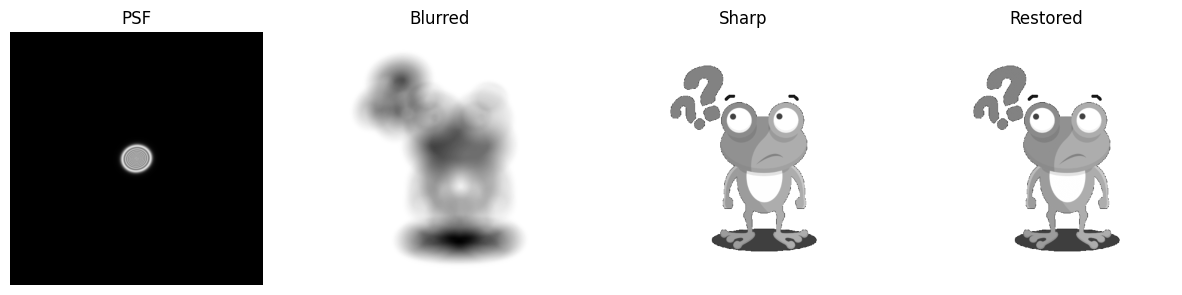

SSIM:  0.9996189840526615
PSNR:  55.618707501445954
MSE:  2.742390209924797e-06


In [5]:
blurred_gray = convolve(image[..., 0], psf)
restored = wiener_gray(blurred_gray, psf, balance=1e-10)

viz_res(psf=psf, sharp_image=image[..., 0], blurred_image=blurred_gray, restored_image=restored)

print('SSIM: ', ssim(image[..., 0].astype(np.float32) / 255, np.clip(restored, 0, 1)))
print('PSNR: ', psnr(image[..., 0].astype(np.float32) / 255, np.clip(restored, 0, 1)))
print('MSE: ', mse(image[..., 0].astype(np.float32) / 255, np.clip(restored, 0, 1)))

### RGB

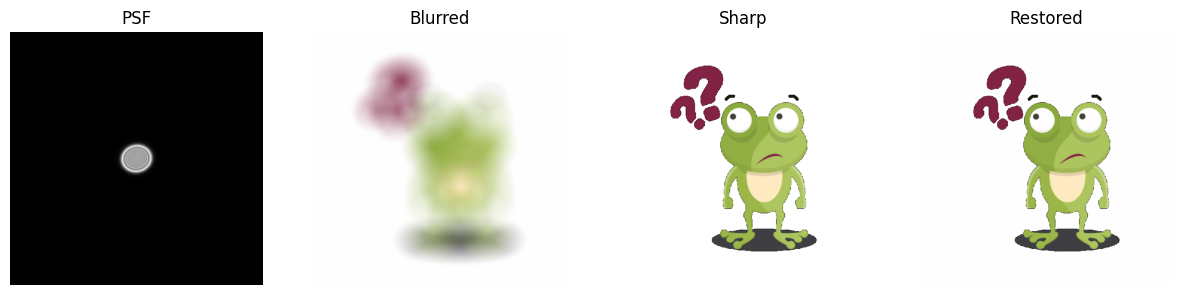

SSIM:  0.9996148
PSNR:  55.65549762414222
MSE:  2.7192568898293128e-06


In [7]:
blurred_rgb = convolve(image, psf)
restored_rgb = wiener_rgb(blurred_rgb, psf, balance=1e-10)

viz_res(psf=psf, sharp_image=image, blurred_image=blurred_rgb / blurred_rgb.max(), restored_image=restored_rgb)

print('SSIM: ', ssim(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1), channel_axis=2))
print('PSNR: ', psnr(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))
print('MSE: ', mse(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))

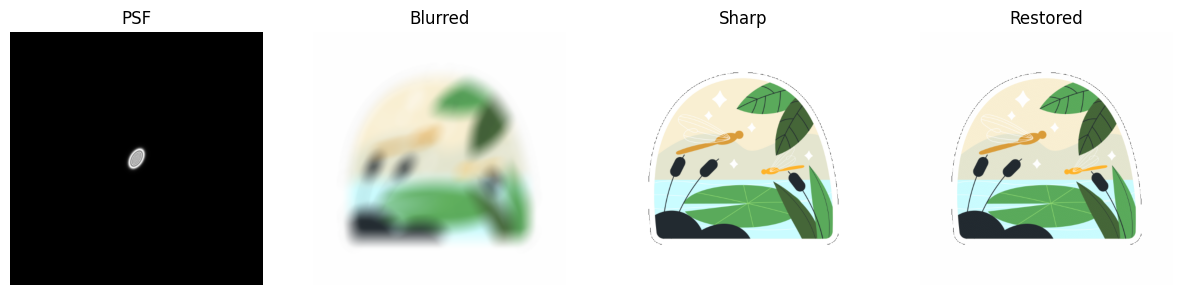

SSIM:  0.9999449
PSNR:  65.23190824396254
MSE:  2.997845008208698e-07


In [8]:
image = read_image(str(icons[1]))
psf = medium_psfs[1]['psf']

blurred_rgb = convolve(image, psf)
restored_rgb = wiener_rgb(blurred_rgb, psf, balance=1e-10)

viz_res(psf=psf, sharp_image=image, blurred_image=blurred_rgb / blurred_rgb.max(), restored_image=restored_rgb)

print('SSIM: ', ssim(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1), channel_axis=2))
print('PSNR: ', psnr(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))
print('MSE: ', mse(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))

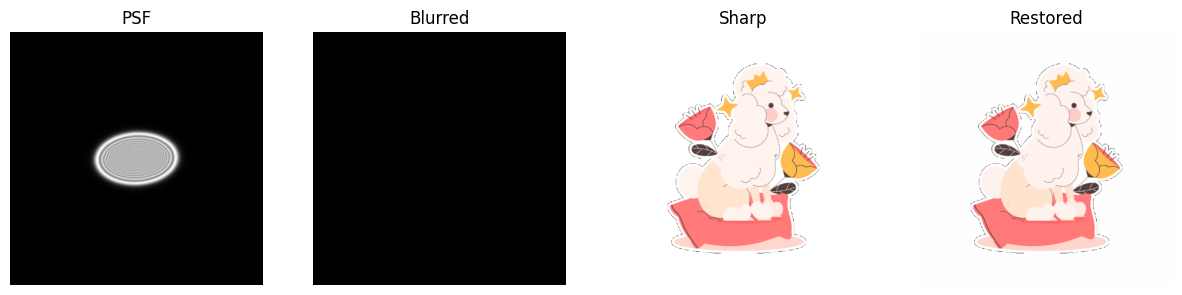

SSIM:  0.9973912
PSNR:  45.53611471979025
MSE:  2.7950432213689414e-05


In [11]:
image = read_image(str(icons[2]))
psf = big_psfs[2]['psf']

blurred_rgb = convolve(image, psf)
restored_rgb = wiener_rgb(blurred_rgb, psf, balance=1e-10)

viz_res(psf=psf, sharp_image=image, blurred_image=blurred_rgb / 255, restored_image=restored_rgb)

print('SSIM: ', ssim(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1), channel_axis=2))
print('PSNR: ', psnr(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))
print('MSE: ', mse(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))

### Noise

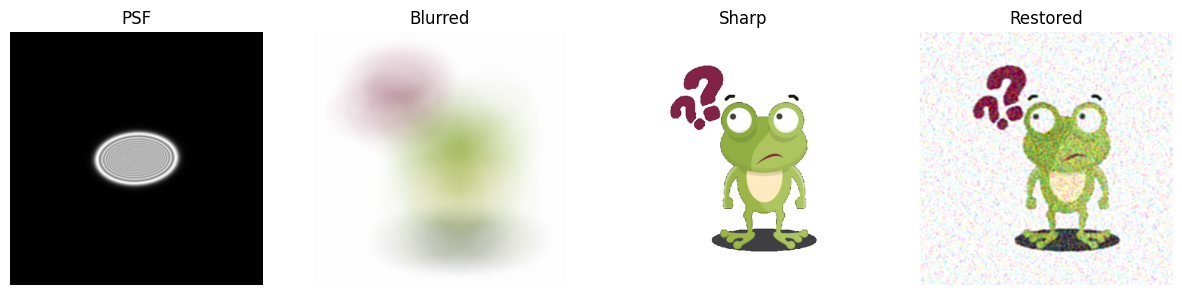

SSIM:  0.7039961
PSNR:  22.184814118201146
MSE:  0.006046702312004006


In [54]:
noise = np.random.normal(loc=0, scale=0.001, size=image.shape)
blurred_rgb = convolve(image, psf) + noise
restored_rgb = wiener_rgb(blurred_rgb, psf, balance=1e-5)

viz_res(psf=psf, sharp_image=image, blurred_image=blurred_rgb / blurred_rgb.max(), restored_image=restored_rgb)

print('SSIM: ', ssim(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1), channel_axis=2))
print('PSNR: ', psnr(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))
print('MSE: ', mse(image.astype(np.float32) / 255, np.clip(restored_rgb, 0, 1)))

In [55]:
noise.min(), noise.mean(), noise.max()

(-0.004858911396120395, 1.8987948547087014e-06, 0.005116896940292595)

## Robustness of Wiener

In [12]:
image = read_image(str(icons[0]))

small = small_psfs[0]
psf_small = small['psf']

medium = medium_psfs[0]
psf_medium = medium['psf']

big = big_psfs[0]
psf_big = big_psfs[0]['psf']

Text(0.5, 1.0, 'PSF | A: -78, C: -0.622, S: -6.457')

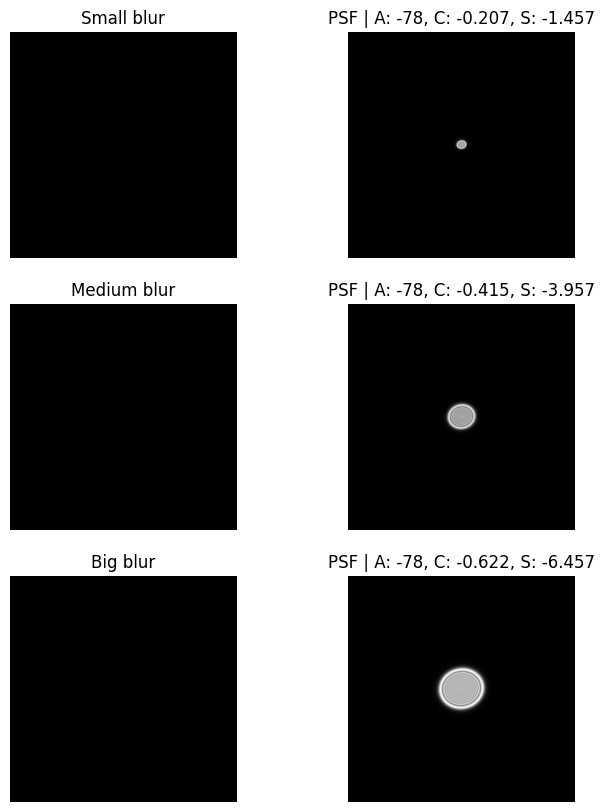

In [13]:
blurred_small = convolve(image, psf_small)
blurred_medium = convolve(image, psf_medium)
blurred_big = convolve(image, psf_big)

fig, axs = plt.subplots(3, 2, figsize=(8, 10))

axs[0, 0].imshow(blurred_small.astype(np.int32))
axs[0, 0].axis('off')
axs[0, 0].set_title(f'Small blur')

axs[0, 1].imshow(psf_small)
axs[0, 1].axis('off')
axs[0, 1].set_title(f'PSF | A: {small["A"]}, C: {small["C"]}, S: {small["S"]}')

axs[1, 0].imshow(blurred_medium.astype(np.int32))
axs[1, 0].axis('off')
axs[1, 0].set_title('Medium blur')

axs[1, 1].imshow(psf_medium)
axs[1, 1].axis('off')
axs[1, 1].set_title(f'PSF | A: {medium["A"]}, C: {medium["C"]}, S: {medium["S"]}')

axs[2, 0].imshow(blurred_big.astype(np.int32))
axs[2, 0].axis('off')
axs[2, 0].set_title('Big blur')

axs[2, 1].imshow(psf_big)
axs[2, 1].axis('off')
axs[2, 1].set_title(f'PSF | A: {big["A"]}, C: {big["C"]}, S: {big["S"]}')

In [22]:
def deblur_and_show(
    sharp_image: np.array,
    psf_correct: np.array,
    psf_incorrect: np.array,
    algorithm: tp.Callable,
    incorr_psf_title: str = 'Incorrect PSF',
    **algo_params,
):
    """Show deblurred image with correct and incorrect PSF."""
    blurred_image = convolve(sharp_image, psf_correct)

    restored_correct = algorithm(
        blurred_image=blurred_image,
        psf=psf_correct,
        **algo_params,
    )

    restored_incorrect = algorithm(
        blurred_image=blurred_image,
        psf=psf_incorrect,
        **algo_params,
    )

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
    [axi.set_axis_off() for axi in ax.ravel()]

    ax[0,0].imshow(np.clip(blurred_image , 0, 1))
    ax[0,0].set_title('Blurred')

    ax[0,1].imshow(sharp_image)
    ax[0,1].set_title('Sharp')

    ax[0,2].imshow(restored_correct)
    ax[0,2].set_title('Deconvolved with correct PSF')

    ax[0,3].imshow(psf_correct)
    ax[0,3].set_title('Correct PSF')

    ax[1,0].imshow(convolve(sharp_image, psf_incorrect))
    ax[1,0].set_title('Blurred with incorrect PSF')

    ax[1,1].imshow(sharp_image)
    ax[1,1].set_title('Sharp')

    ax[1,2].imshow(restored_incorrect)
    ax[1,2].set_title('Deconvolved with incorrect PSF')

    ax[1,3].imshow(psf_incorrect)
    ax[1,3].set_title(incorr_psf_title)

### Results

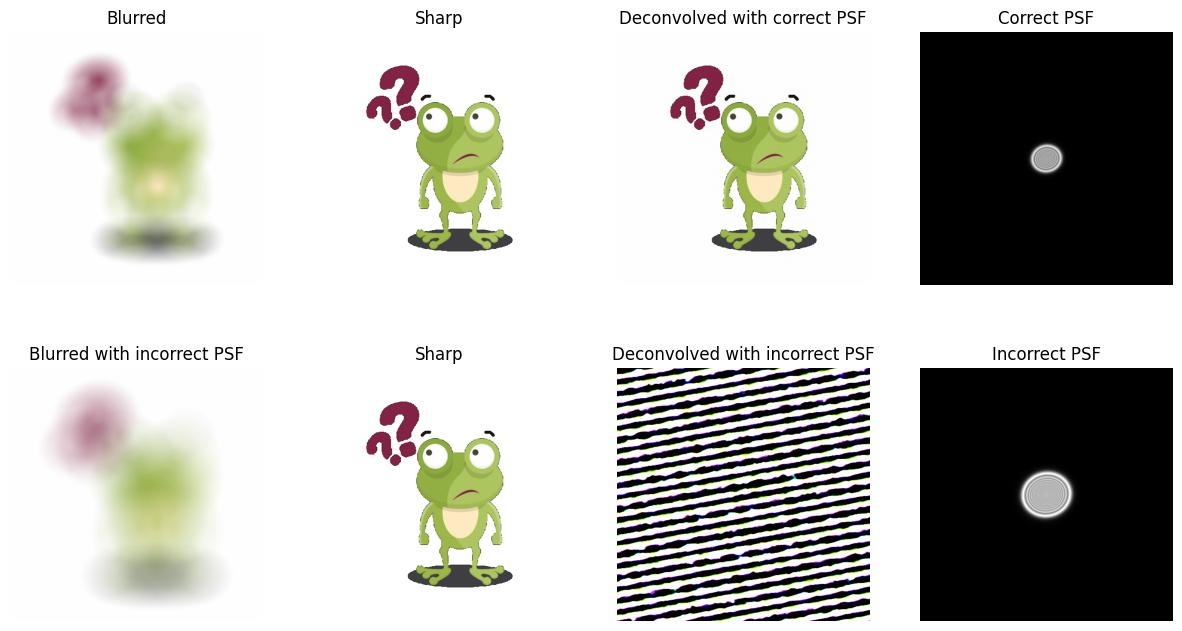

In [41]:
deblur_and_show(
    sharp_image=image,
    psf_correct=psf_medium,
    psf_incorrect=psf_big,
    algorithm=wiener_rgb,
    balance=1e-8,
)

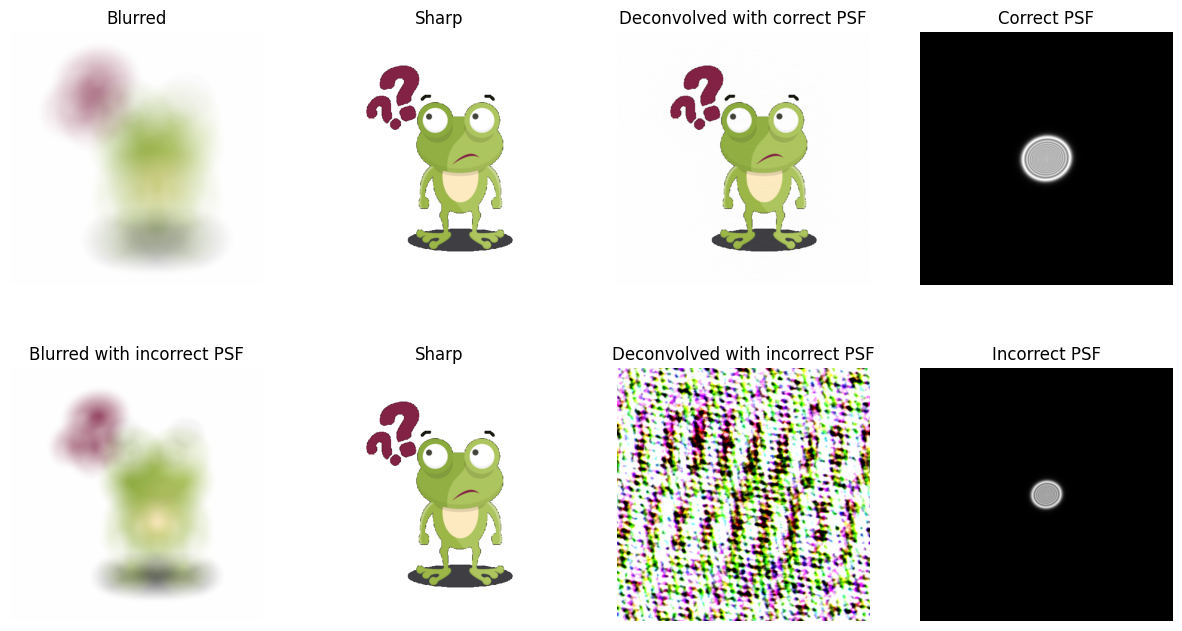

In [40]:
deblur_and_show(
    sharp_image=image,
    psf_correct=psf_big,
    psf_incorrect=psf_medium,
    algorithm=wiener_rgb,
    balance=1e-8,
)

### Blur PSF with gauss filter

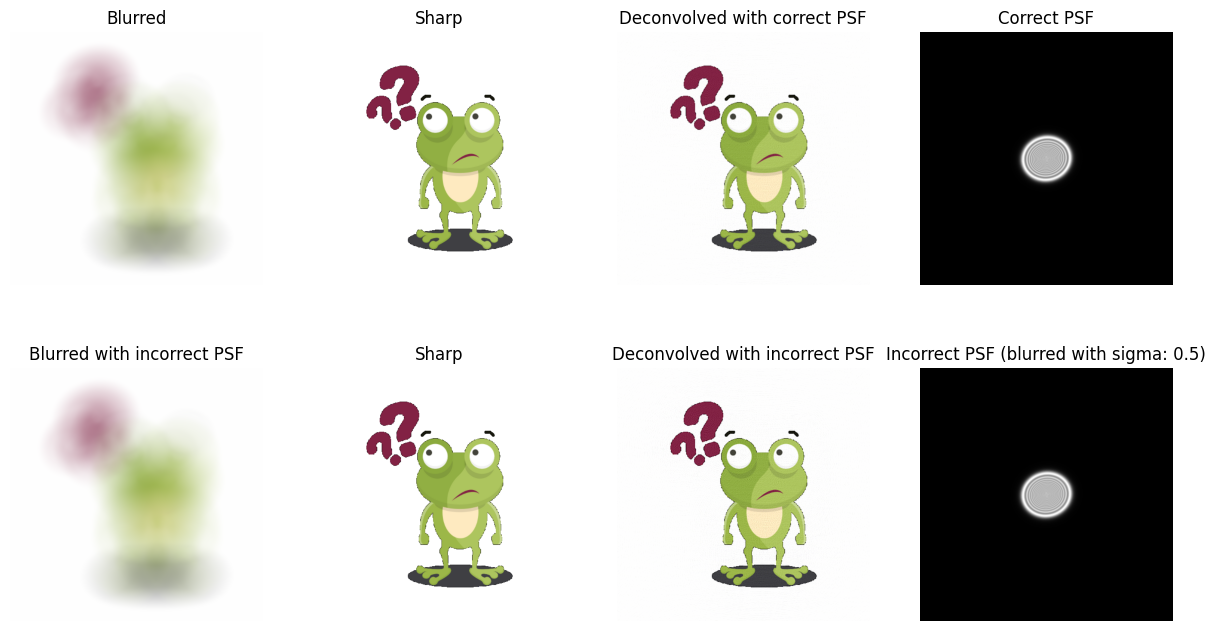

In [39]:
sigma = 0.5

deblur_and_show(
    sharp_image=image,
    psf_correct=psf_big,
    psf_incorrect=gaussian(psf_big, sigma=sigma),
    algorithm=wiener_rgb,
    balance=1e-8,
    incorr_psf_title = f'Incorrect PSF (blurred with sigma: {sigma})'
)

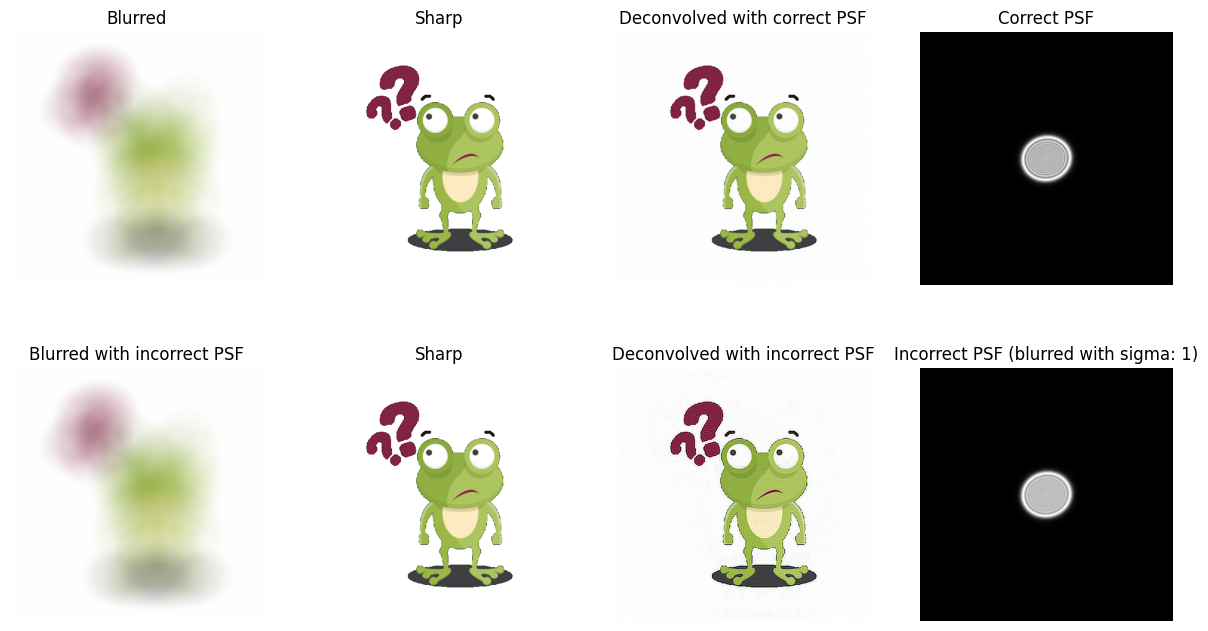

In [38]:
sigma = 1

deblur_and_show(
    sharp_image=image,
    psf_correct=psf_big,
    psf_incorrect=gaussian(psf_big, sigma=sigma),
    algorithm=wiener_rgb,
    balance=1e-8,
    incorr_psf_title = f'Incorrect PSF (blurred with sigma: {sigma})'
)

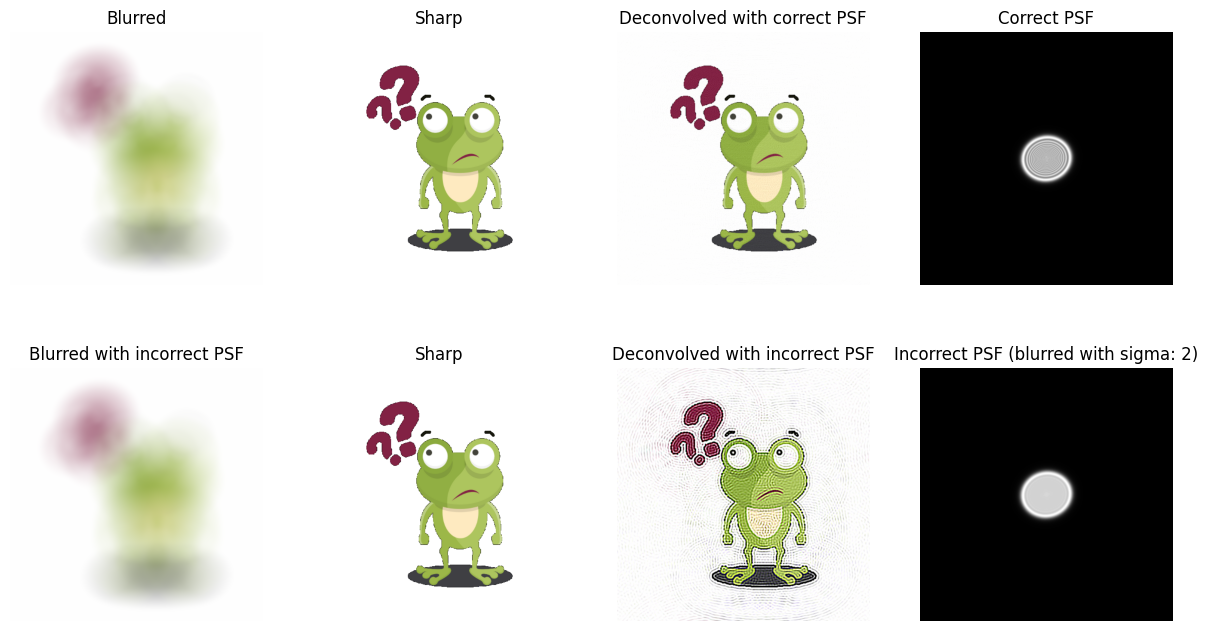

In [37]:
sigma = 2

deblur_and_show(
    sharp_image=image,
    psf_correct=psf_big,
    psf_incorrect=gaussian(psf_big, sigma=sigma),
    algorithm=wiener_rgb,
    balance=1e-8,
    incorr_psf_title = f'Incorrect PSF (blurred with sigma: {sigma})'
)

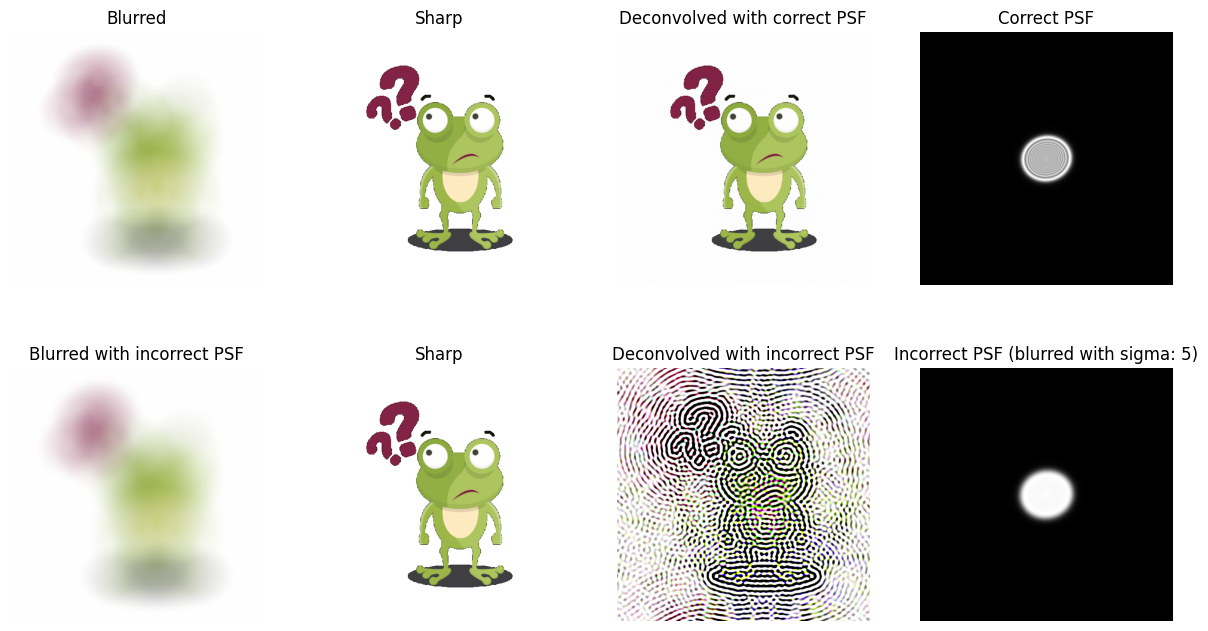

In [35]:
sigma = 5

deblur_and_show(
    sharp_image=image,
    psf_correct=psf_big,
    psf_incorrect=gaussian(psf_big, sigma=sigma),
    algorithm=wiener_rgb,
    balance=1e-8,
    incorr_psf_title = f'Incorrect PSF (blurred with sigma: {sigma})'
)

 Images blurred with "correct" and "incorrect" (with gauss blur applied to PSF) PSF are almost the same:

In [36]:
psf_correct = psf_big
psf_incorrect = gaussian(psf_big, sigma=5)

print('SSIM: ', ssim(convolve(image, psf_correct) / 255, convolve(image, psf_incorrect) / 255, channel_axis=2))
print('PSNR: ', psnr(convolve(image, psf_correct) / 255, convolve(image, psf_incorrect) / 255))
print('MSE: ', mse(convolve(image, psf_correct) / 255, convolve(image, psf_incorrect) / 255))

SSIM:  0.9999998
PSNR:  103.42372700523475
MSE:  4.545977684150941e-11
